In [1]:
%matplotlib widget

In [2]:
import rocketpy
from rocketpy import *
import numpy as np
import matplotlib.pyplot as plt

print(rocketpy.__version__)

0.9.9


In [4]:
# Create an environment with ZERO gravity and CONTROLLED wind
Env = Environment(
    gravity=0, # zero gravity
    railLength=0,
    latitude=0,
    longitude=0,
    elevation=0
)
Env.setAtmosphericModel(
    type="CustomAtmosphere",
    wind_u=10, # 10 m/s constant wind velocity in the east direction
    wind_v=0,
    pressure=101325,
    temperature=300,
)

In [5]:
# Create a motor with ZERO thrust and ZERO mass
DummyMotor = SolidMotor(
    thrustSource=1e-300,
    burnOut=1e-10,
    grainNumber=5,
    grainSeparation=5/1000,
    grainDensity=1e-300,
    grainOuterRadius=33/1000,
    grainInitialInnerRadius=15/1000,
    grainInitialHeight=120/1000,
    nozzleRadius=33/1000,
    throatRadius=11/1000,
)

In [6]:
# Create a rocket with ZERO drag
DummyRocket = Rocket(
    motor=DummyMotor,
    radius=127/2000,
    mass=19.197-2.956,
    inertiaI=6.60,
    inertiaZ=0.0351,
    distanceRocketNozzle=-1.255,
    distanceRocketPropellant=-0.85704,
    powerOffDrag=0,
    powerOnDrag=0
)

DummyRocket.setRailButtons([0.2, -0.5])
NoseCone = DummyRocket.addNose(length=0.55829, kind="vonKarman", distanceToCM=0.71971)
FinSet = DummyRocket.addFins(4, span=0.100, rootChord=0.120, tipChord=0.040, distanceToCM=-1.04956)
Tail = DummyRocket.addTail(topRadius=0.0635, bottomRadius=0.0435, length=0.060, distanceToCM=-1.194656)

In [7]:
# Simulate Flight
TestFlight = Flight(
    rocket=DummyRocket,
    environment=Env,
    inclination=90,
    heading=0,
    initialSolution=[0, 0, 0, 100, 0, 0, 100, 1.0, 0.0, 0.0, 0.0, 0, 0, 0], # Start at 100 m of altitude and 100 m/s of vertical velocity
    maxTime=10,
    maxTimeStep=1e-3,
    verbose=True
)
TestFlight.postProcess(interpolation="linear", extrapolation="natural")
# TestFlight.allInfo()

Simulation Completed at Time: 10.0000 s


In [8]:
# Function to get rocket with any desired static margin easily
def setup_rocket_with_given_static_margin(rocket, static_margin):

    def compute_static_margin_error_given_distance(distanceToCM, static_margin, rocket):
        rocket.aerodynamicSurfaces = []
        rocket.addNose(length=0.5, kind="vonKarman", distanceToCM=1.0)
        rocket.addFins(4, span=0.100, rootChord=0.100, tipChord=0.100, distanceToCM=distanceToCM) 
        return rocket.staticMargin(0) - static_margin
    
    from scipy import optimize
    sol = optimize.root_scalar(compute_static_margin_error_given_distance, bracket=[-2.0, 2.0], method='brentq', args=(static_margin, rocket))

    return rocket

DummyRocket = setup_rocket_with_given_static_margin(DummyRocket, static_margin=-1.5)

print(DummyRocket.staticMargin(1))

-1.5000000000050808


In [10]:
def augmented_angle_of_attack_theoretical_function(time, A, B, w, z):
    return np.real(A*np.exp(1j*w*time) + B*np.exp(-1j*w*time))*np.exp(z*time)

Simulating Rocket with Static Margin of -0.100
Simulation Completed at Time: 7.0000 s
Simulating Rocket with Static Margin of -0.010
Simulation Completed at Time: 7.0000 s
Simulating Rocket with Static Margin of -0.000
Simulation Completed at Time: 7.0000 s
Simulating Rocket with Static Margin of 0.010
Simulation Completed at Time: 7.0000 s
Simulating Rocket with Static Margin of 0.100
Simulation Completed at Time: 7.0000 s
Simulating Rocket with Static Margin of 1.000
Simulation Completed at Time: 7.0000 s


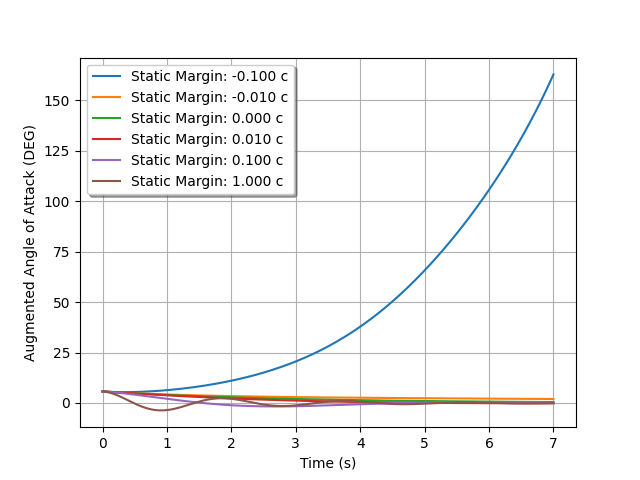

In [11]:
# Simulate Different Static Margins by Varying Fin Position
simulation_results = []
fitted_values = []
max_time = 7

for static_margin in [-0.1, -0.01, 0, 0.01, 0.1, 1.0]:
    DummyRocket = setup_rocket_with_given_static_margin(DummyRocket, static_margin)

    # Simulate
    print(f'Simulating Rocket with Static Margin of {DummyRocket.staticMargin(0):1.3f}')
    TestFlight = Flight(
        rocket=DummyRocket, environment=Env,
        inclination=90, heading=0,
        initialSolution=[0, 0, 0, 100, 0, 0, 100, 1.0, 0.0, 0.0, 0.0, 0, 0, 0], # Start at 100 m of altitude and 100 m/s of vertical velocity
        maxTime=max_time, maxTimeStep=1e-2,
        verbose=True
    )
    TestFlight.postProcess(interpolation="linear", extrapolation="natural")    # Compute Augmented Angle of Attack

    # Augmented Angle of Attack
    timeSource = TestFlight.angleOfAttack.source[:, 0]
    angleOfAttackSource = TestFlight.angleOfAttack.source[:, 1]
    # Loop through the data and invert sign when a first derivative singularity is found near zero
    for i in range(0, len(angleOfAttackSource)-2, 1):
        i0, i1, i2 = i, i + 1, i + 2
        x0, x1, x2 = timeSource[([i0, i1, i2])]
        y0, y1, y2 = angleOfAttackSource[([i0, i1, i2])]
        y2_linear_prediction = y1 + ((y1 - y0)/(x1 - x0))*(x2 - x1)
        if np.sign(y2) != np.sign(y2_linear_prediction):
            angleOfAttackSource[i+2:] *= -1
    # Make sure maximum angle of attack is positive (convetion)
    if np.max(np.abs(angleOfAttackSource)) == -1*np.min(angleOfAttackSource):
        angleOfAttackSource = -1*angleOfAttackSource
    # Transform data into function
    augmentedAngleOfAttack = Function(
        np.array([timeSource, angleOfAttackSource]).transpose(),
        inputs='Time',
        outputs='Augmented Angle of Attack (DEG)'
    )

    # Store Results
    simulation_results += [(augmentedAngleOfAttack, f'Static Margin: {static_margin:.3f} c')]

    # Fit augmented angle of attack curve
    from scipy import optimize
    popt, pcov = optimize.curve_fit(augmented_angle_of_attack_theoretical_function, timeSource, angleOfAttackSource)
    theoreticalAugmentedAngleOfAttack = Function(
        np.array([timeSource, augmented_angle_of_attack_theoretical_function(timeSource, *popt)]).transpose(),
        inputs='Time',
        outputs='Theoretical Augmented Angle of Attack (DEG)'
    )
    # simulation_results += [(theoreticalAugmentedAngleOfAttack, f'Fitted - Static Margin: {static_margin:.3f} c')]
    fitted_values += [(popt, f'Static Margin: {static_margin:.3f} c')]

Function.comparePlots(simulation_results, lower=0, upper=max_time, xlabel='Time (s)', ylabel='Augmented Angle of Attack (DEG)')

In [12]:
fitted_values

[(array([0.01632274, 0.14708815, 1.07998145, 1.09671736]),
  'Static Margin: -0.100 c'),
 (array([ 1.75584946e+03, -1.75593120e+03,  6.72428545e-01,  6.71191834e-01]),
  'Static Margin: -0.010 c'),
 (array([-2.99046199e+03,  2.99617261e+03,  3.51354962e-04, -3.53551230e-01]),
  'Static Margin: 0.000 c'),
 (array([ 1.75585292e+03, -1.75586082e+03,  1.04843976e+00,  5.42382160e-01]),
  'Static Margin: 0.010 c'),
 (array([-9.55929173e+03,  9.56512275e+03,  1.02319091e+00, -4.25697732e-01]),
  'Static Margin: 0.100 c'),
 (array([-3.26129944e+04,  3.26187513e+04, -3.31543819e+00, -4.78319665e-01]),
  'Static Margin: 1.000 c')]

# Time tests

In [32]:
%timeit TestFlight.postProcess(interpolation="spline", extrapolation="natural")

13.5 s ± 601 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [33]:
%timeit TestFlight.postProcess(interpolation="linear", extrapolation="natural")

4.3 s ± 360 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
